In [1]:
import regression as r

In [2]:
icgem_data_gravity_ell = r.hm.load_icgem_gdf("data/south-atlantic/gravity_ell_EIGEN-6C4_5356c5f42a312695eabd65ae655e9dff12a23b3d7abf04a75ffcf294a8d022ba.gdf")
icgem_data_topography = r.hm.load_icgem_gdf("data/south-atlantic/topography_grd_etopo1-2250_4266472118e1ccb246e3435eeba94f22f0c59330cacc3a5fafbba452ed726c6d.gdf")
icgem_data_geoid = r.hm.load_icgem_gdf("data/south-atlantic/geoid_EIGEN-6C4_dad5641c3390b1ed3d9778f1575d22361bfe6e80ab465785af9ced6f09617d2b.gdf")

In [3]:
data = r.xr.merge(
    [icgem_data_gravity_ell.rename({'gravity_ell': 'gravity'}), icgem_data_topography.rename({'topography_grd': 'topography'}), icgem_data_geoid]
)

In [4]:
gamma = r.bl.WGS84.normal_gravity(data.latitude, 10000) # gravidade teórica da Terra elipsoidal

disturbance = data.gravity - gamma # medido pelo gravímetro subtraido pela teórica

topography_adjust = data.topography + data.geoid # ajustando a diferença de topografia entre geoide e elipsoide, a altura do geoide é em relação ao elipsoide

bouguer_corr = r.hm.bouguer_correction(topography_adjust)

data['dg_bouguer'] = disturbance - bouguer_corr

data

<xarray.Dataset> Size: 6MB
Dimensions:          (latitude: 346, longitude: 401)
Coordinates:
  * latitude         (latitude) float64 3kB -57.0 -56.8 -56.6 ... 11.6 11.8 12.0
  * longitude        (longitude) float64 3kB -57.0 -56.8 -56.6 ... 22.8 23.0
Data variables:
    gravity          (latitude, longitude) float64 1MB 9.786e+05 ... 9.752e+05
    height_over_ell  (latitude, longitude) float64 1MB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 1MB -4.207e+03 ... 651.0
    geoid            (latitude, longitude) float64 1MB 19.83 19.82 ... 4.775
    dg_bouguer       (latitude, longitude) float64 1MB 320.2 277.7 ... -70.66
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/05
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.7864506E+05 mgal
    minvalue:              9.7490335E+05 mgal
    signal_wrms:           1.0805756E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [5]:
topo_raw = data.topography.values.ravel()
dg_raw = data.dg_bouguer.values.ravel()
    
region = r.vd.get_region((data.longitude.values, data.latitude.values))
lon_grid, lat_grid = r.vd.grid_coordinates(region=region, shape=data.topography.shape, meshgrid=True)
lon_raw, lat_raw = lon_grid.ravel(), lat_grid.ravel()

mask = ~r.np.isnan(topo_raw) & ~r.np.isnan(dg_raw)
h, d = topo_raw[mask], dg_raw[mask]
lon, lat = lon_raw[mask], lat_raw[mask]

In [6]:
df_windows, indices = r.windows_regression(data, h, d, lon, lat, window_size=3.0, overlap=0.5)
df_windows.to_csv('df_windows.csv')

df_windows_mixed_coefs = df_windows.dropna(subset = ['a_o', 'a_c', 'b'])
df_windows_mixed_coefs.to_csv('df_windows_mixed_coefs.csv')

df_windows_ocean = df_windows[df_windows['a_c'].isna()]
df_windows_ocean.to_csv('df_windows_ocean.csv')

df_windows_continent = df_windows[df_windows['a_o'].isna()]
df_windows_continent.to_csv('df_windows_continent.csv')

df_fodase = df_windows[df_windows['r2'] < 0.7]
df_fodase.to_csv('df_fodase.csv')

df_windows


 0 janelas foram ignoradas por falta de dados.


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
0,-54.351724,-55.5,-0.075104,NaN,-5.829823,0.987805,0,416,416,0
1,-51.683744,-55.5,-0.073807,NaN,-3.727602,0.986600,1,416,416,0
2,-49.015763,-55.5,-0.068771,NaN,18.479964,0.981571,2,432,432,0
3,-46.347783,-55.5,-0.068279,NaN,21.377126,0.987958,3,416,416,0
4,-43.679803,-55.5,-0.070329,NaN,12.760186,0.996341,4,416,416,0
...,...,...,...,...,...,...,...,...,...,...
2041,15.318542,10.5,NaN,-0.105438,0.843043,0.860839,2041,256,0,256
2042,16.857520,10.5,NaN,-0.157980,15.578504,0.800953,2042,240,0,240
2043,18.396498,10.5,NaN,-0.107262,-6.625764,0.634045,2043,240,0,240
2044,19.935476,10.5,NaN,-0.032236,-43.185787,0.104948,2044,240,0,240


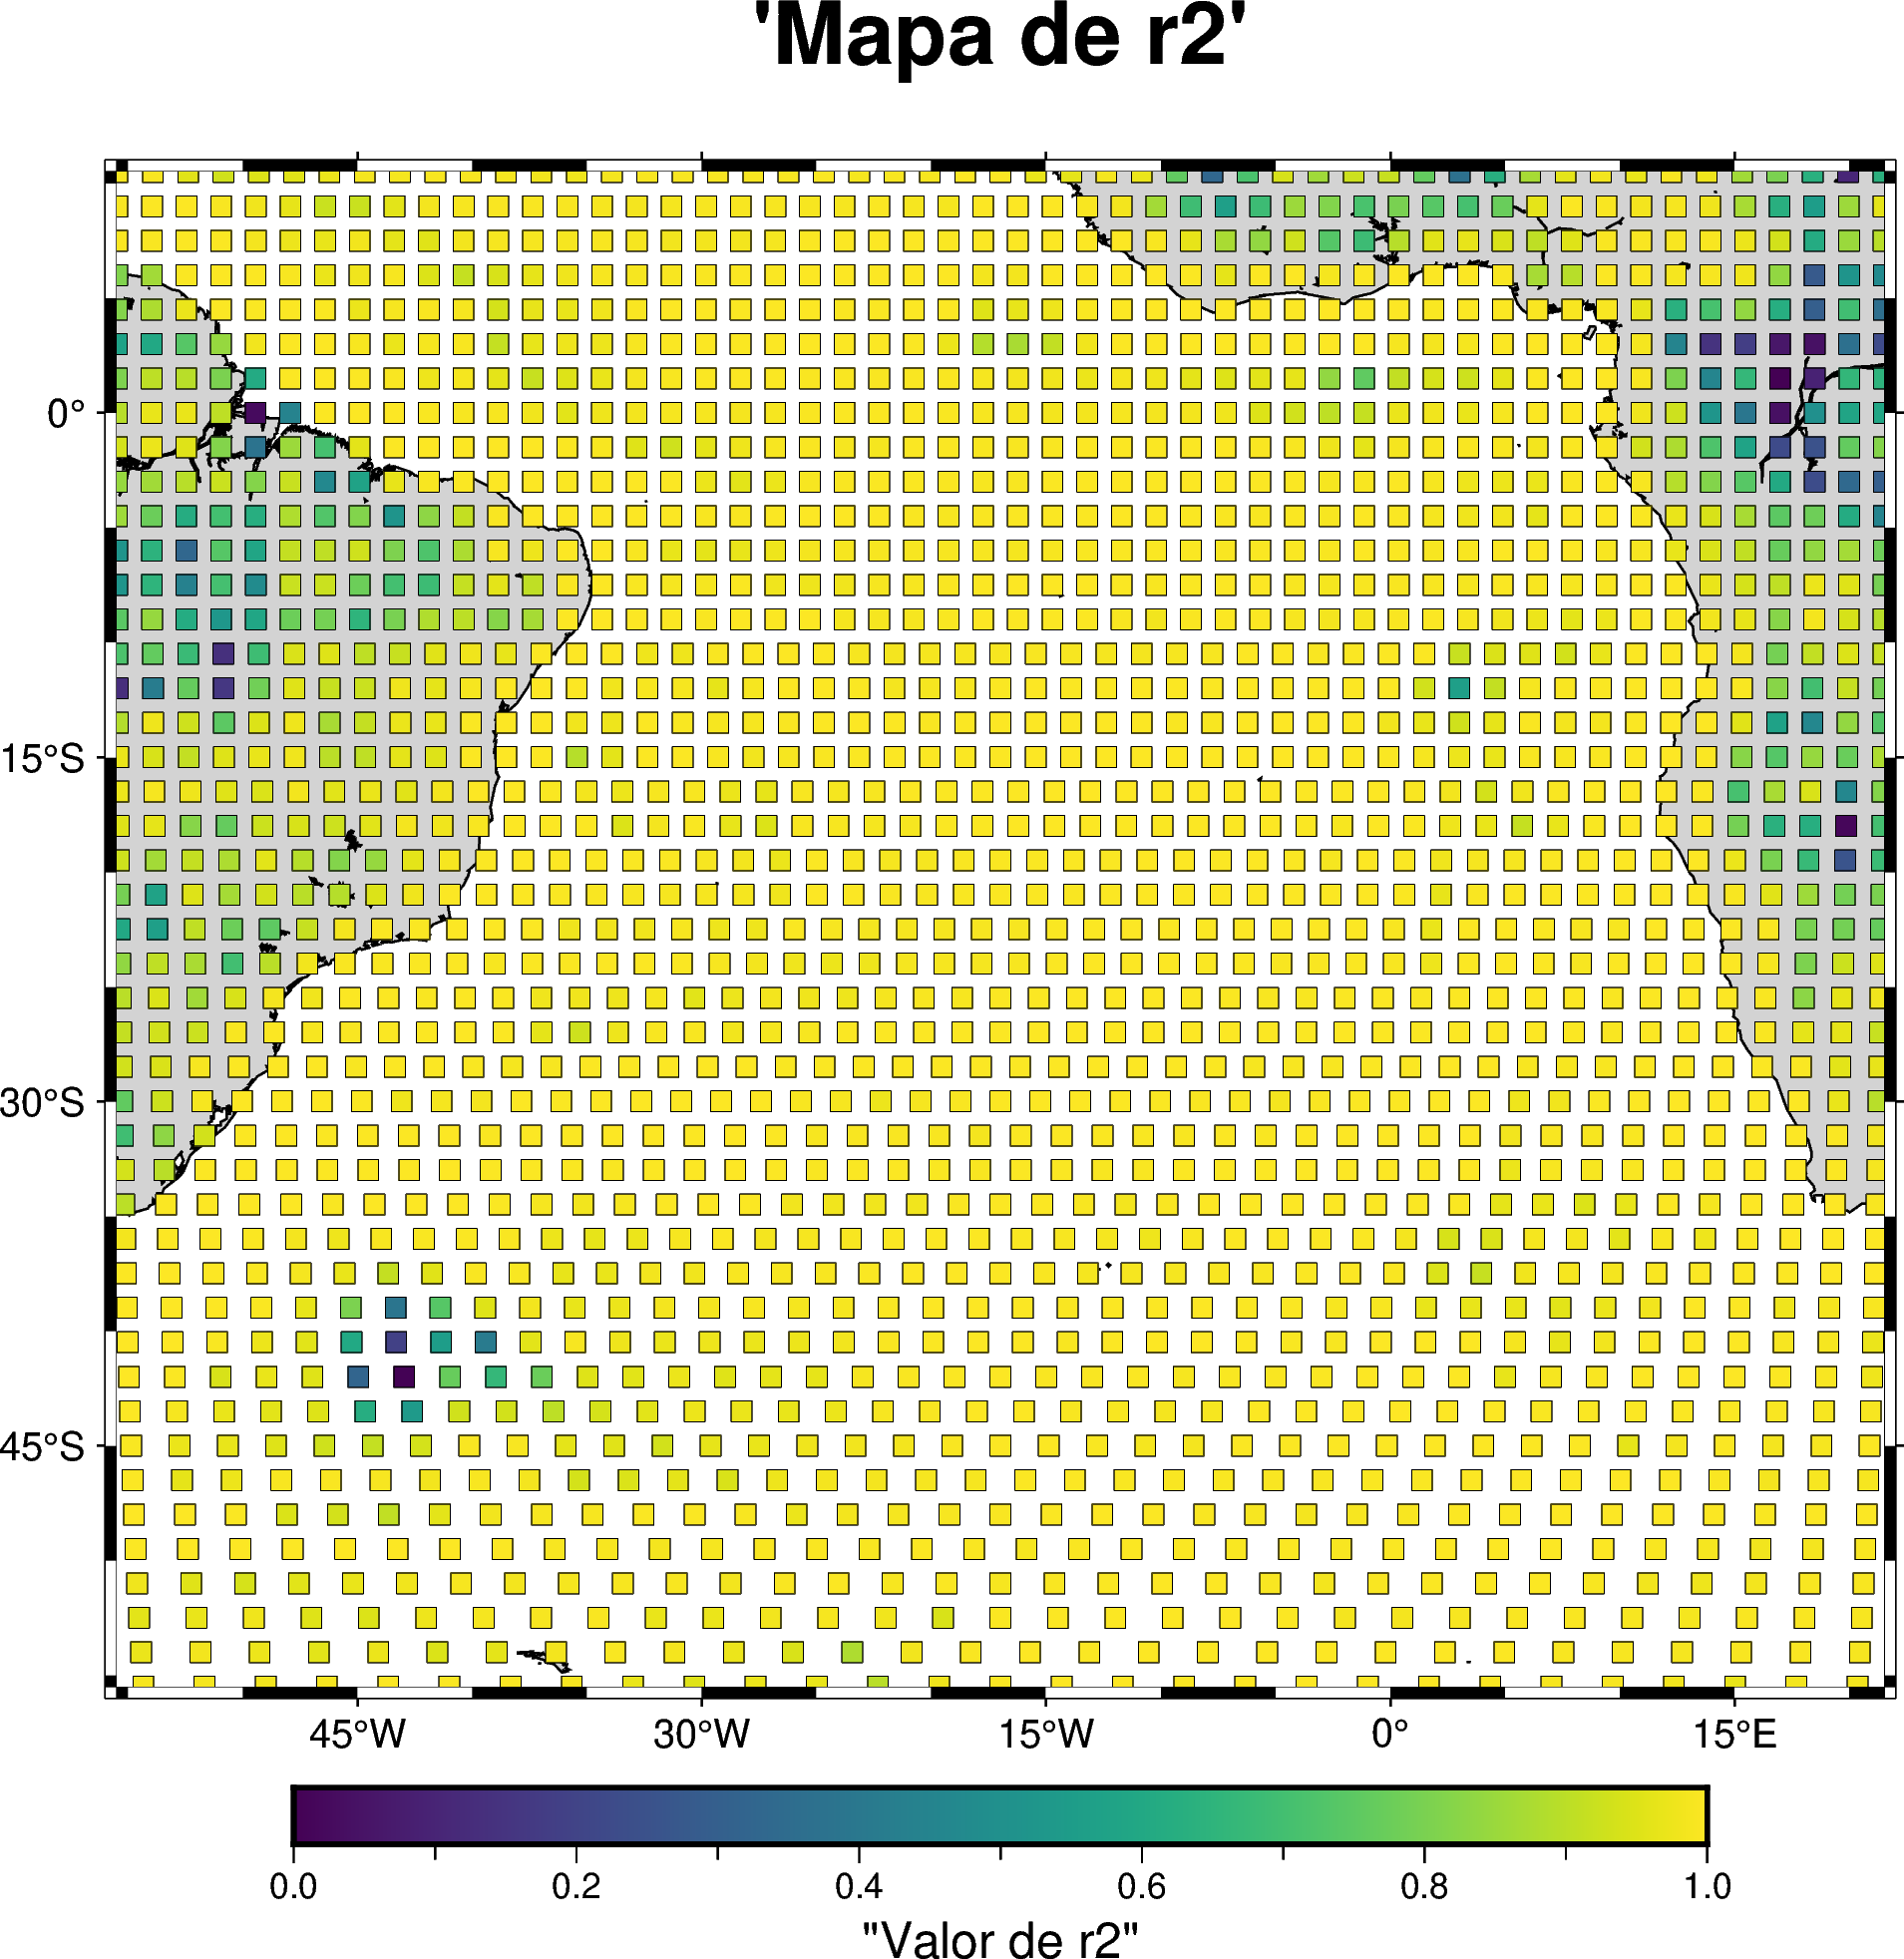

In [7]:
fig_r2 = r.plot_parameters_map(df_windows, 'r2', v_range = [0, 1], step = 0.01, cmap='viridis', reverse=False)
fig_r2.savefig('mapa-r2.png')

fig_a_o = r.plot_parameters_map(df_windows, 'a_o', v_range = [-2, 2], step = 0.01, cmap = 'polar', reverse = False)
fig_a_o.savefig('mapa-a_o.png')

fig_a_c = r.plot_parameters_map(df_windows, 'a_c', v_range = [-2, 2], step = 0.01, cmap = 'polar', reverse = False)
fig_a_c.savefig('mapa-a_c.png')

fig_r2.show()

# Acessando a janela mais próxima dadas as coordenadas

In [8]:
# achando janela mais próxima a um ponto dada a coordenada 
lon_window = 3.5
lat_window = -12


distances = r.np.sqrt((df_windows['longitude'] - lon_window)**2 + (df_windows['latitude'] - lat_window)**2)

distances

window_minor_distance = distances.idxmin()
line_in_df_minor_distance = df_windows.loc[df_windows['original-idx'] == window_minor_distance]

line_in_df_minor_distance


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
1255,3.002574,-12.0,-0.039564,NaN,155.204678,0.560788,1255,225,225,0


In [9]:
idx_current = indices[window_minor_distance][0]
idx_current

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

idx_sort = r.np.argsort(h_window_raw)
h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window)
a_ocean_window, a_continent_window, intercept_window, r2_window = p_window

p_window

(np.float64(-0.03956409090415239),
 nan,
 np.float64(155.20467797829463),
 np.float64(0.5607882870668042))

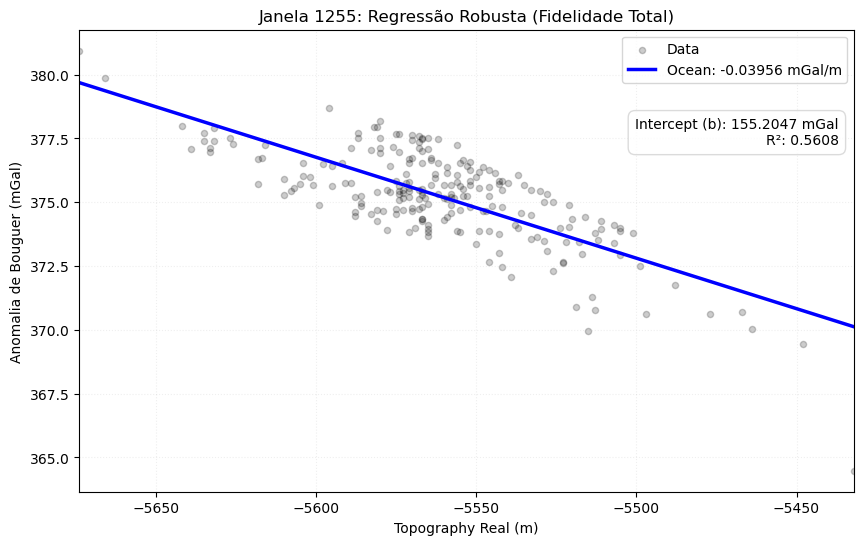

In [10]:
r.plot_window_regression(window_minor_distance, h_window, d_window, a_ocean_window, a_continent_window, intercept_window, r2_window)

O círculo rosa é a localização da janela.



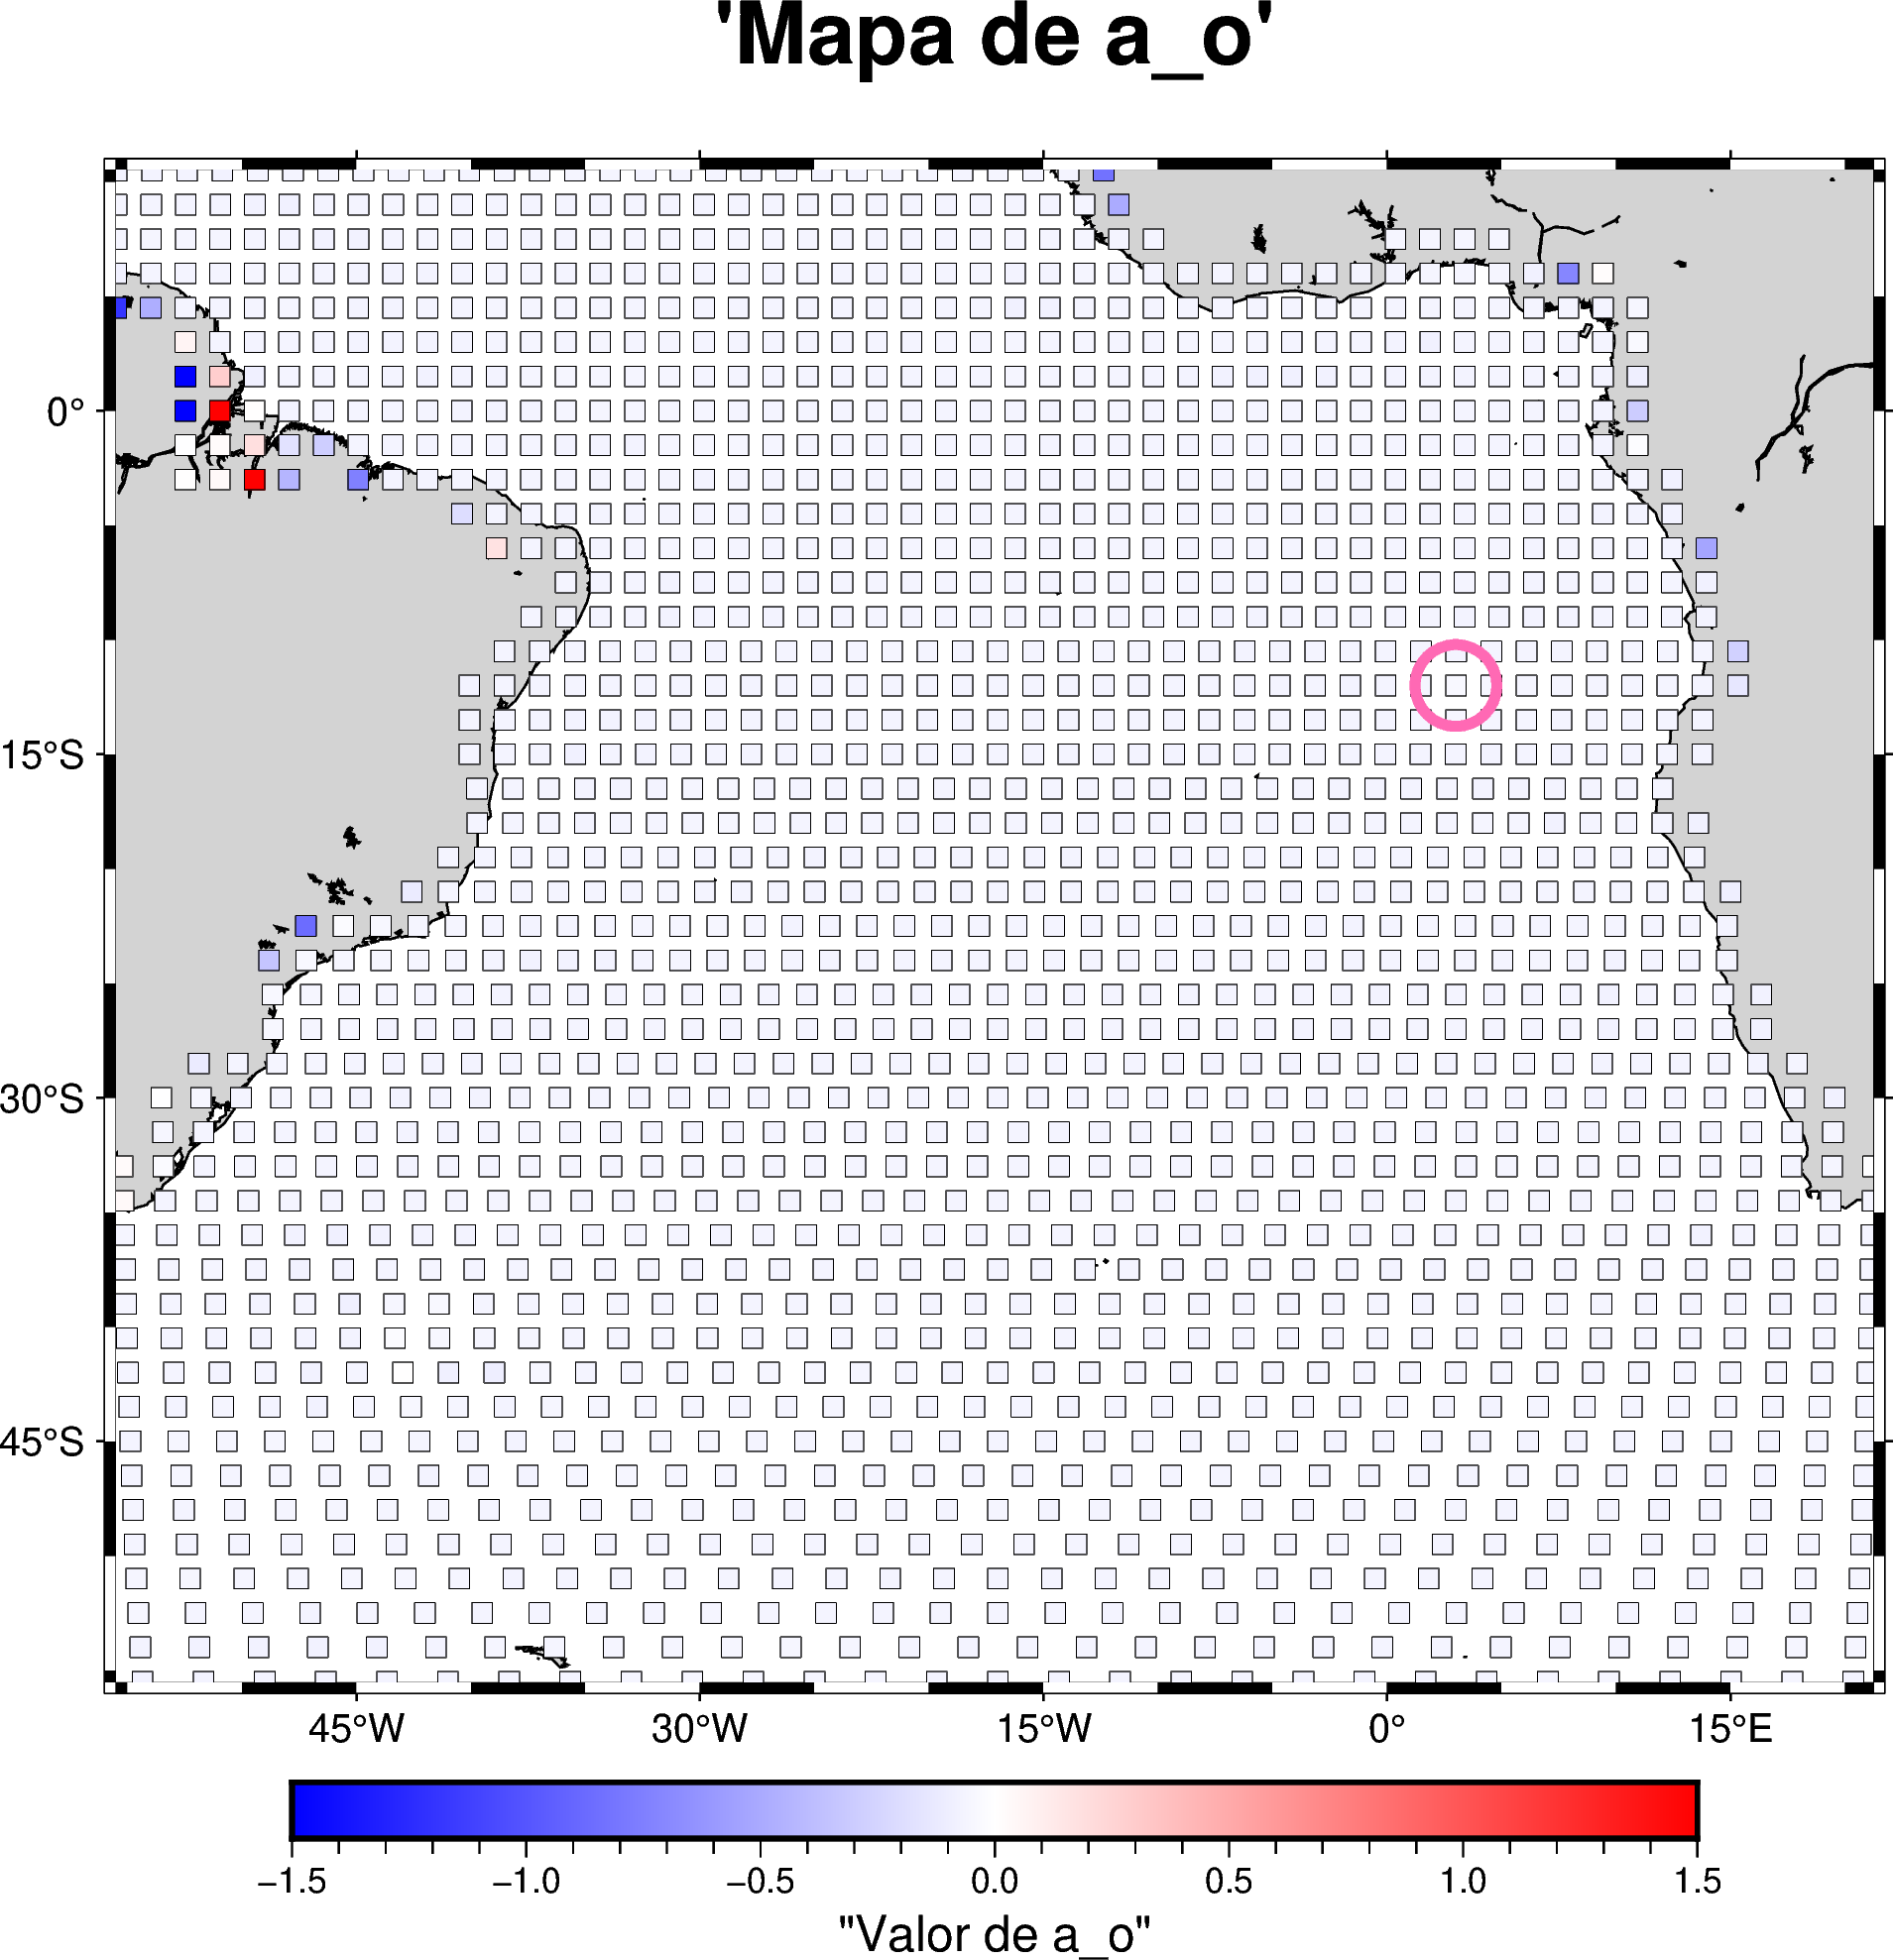

In [11]:
lon_alvo = df_windows.loc[window_minor_distance, 'longitude']
lat_alvo = df_windows.loc[window_minor_distance, 'latitude']

# 2. Gerar o mapa base (ele retorna o objeto 'fig')
fig = r.plot_parameters_map(df_windows, 'a_o', v_range=[-1.5, 1.5], step=0.01, cmap='polar', reverse=False)

# 3. Desenhar um círculo de destaque sobre o mapa
# Criamos um "efeito de borda" com dois círculos sobrepostos
fig.plot(
    x=lon_alvo, 
    y=lat_alvo, 
    style='c0.7c', 
    pen='2.5p,hotpink' 
)

print('O círculo rosa é a localização da janela.')
print()
fig.show()

# Acessando janela específica

In [20]:
# janela especifica que quero acessar
i_wished_window = 1585
line_in_df = df_windows.loc[df_windows['original-idx'] == i_wished_window] # localizo original-idx

if not line_in_df.empty: # para caso a linha não esteja no df 
    lon = line_in_df['longitude'].values[0] # [0] para o pandas não bugar, ele ve values como filtro
    lat = line_in_df['latitude'].values[0]

    print(f'A janela {i_wished_window} tem coordenadas: Longitude {lon:.2f} e Latitude {lat:.2f}')

else:
    print(f'A janela não está no df e pode ter sido descartada ou está vazia')

line_in_df

A janela 1585 tem coordenadas: Longitude -46.44 e Latitude -1.50


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
1585,-46.440783,-1.5,-0.288081,-0.198399,-17.074693,0.705117,1585,240,81,159


In [21]:
idx_current = indices[i_wished_window][0]

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

# crio uma lista com os índices de h_window_raw que colocam o array em ordem numérica ex: [28, 3, 87] é o que deicaria o array em ordem
idx_sort = r.np.argsort(h_window_raw)
h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window)
a_ocean_window, a_continent_window, intercept_window, r2_window = p_window

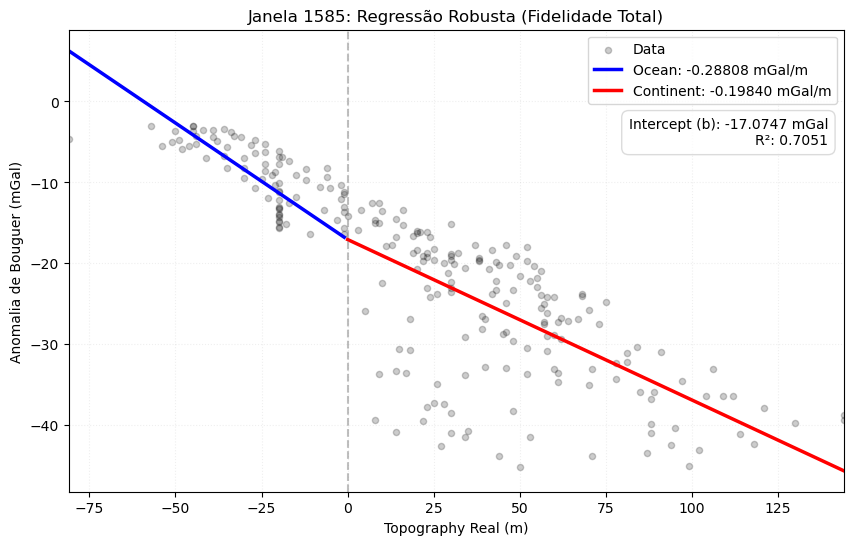

In [22]:
r.plot_window_regression(i_wished_window, h_window, d_window, a_ocean_window, a_continent_window, intercept_window, r2_window)

O círculo rosa é a localização da janela.



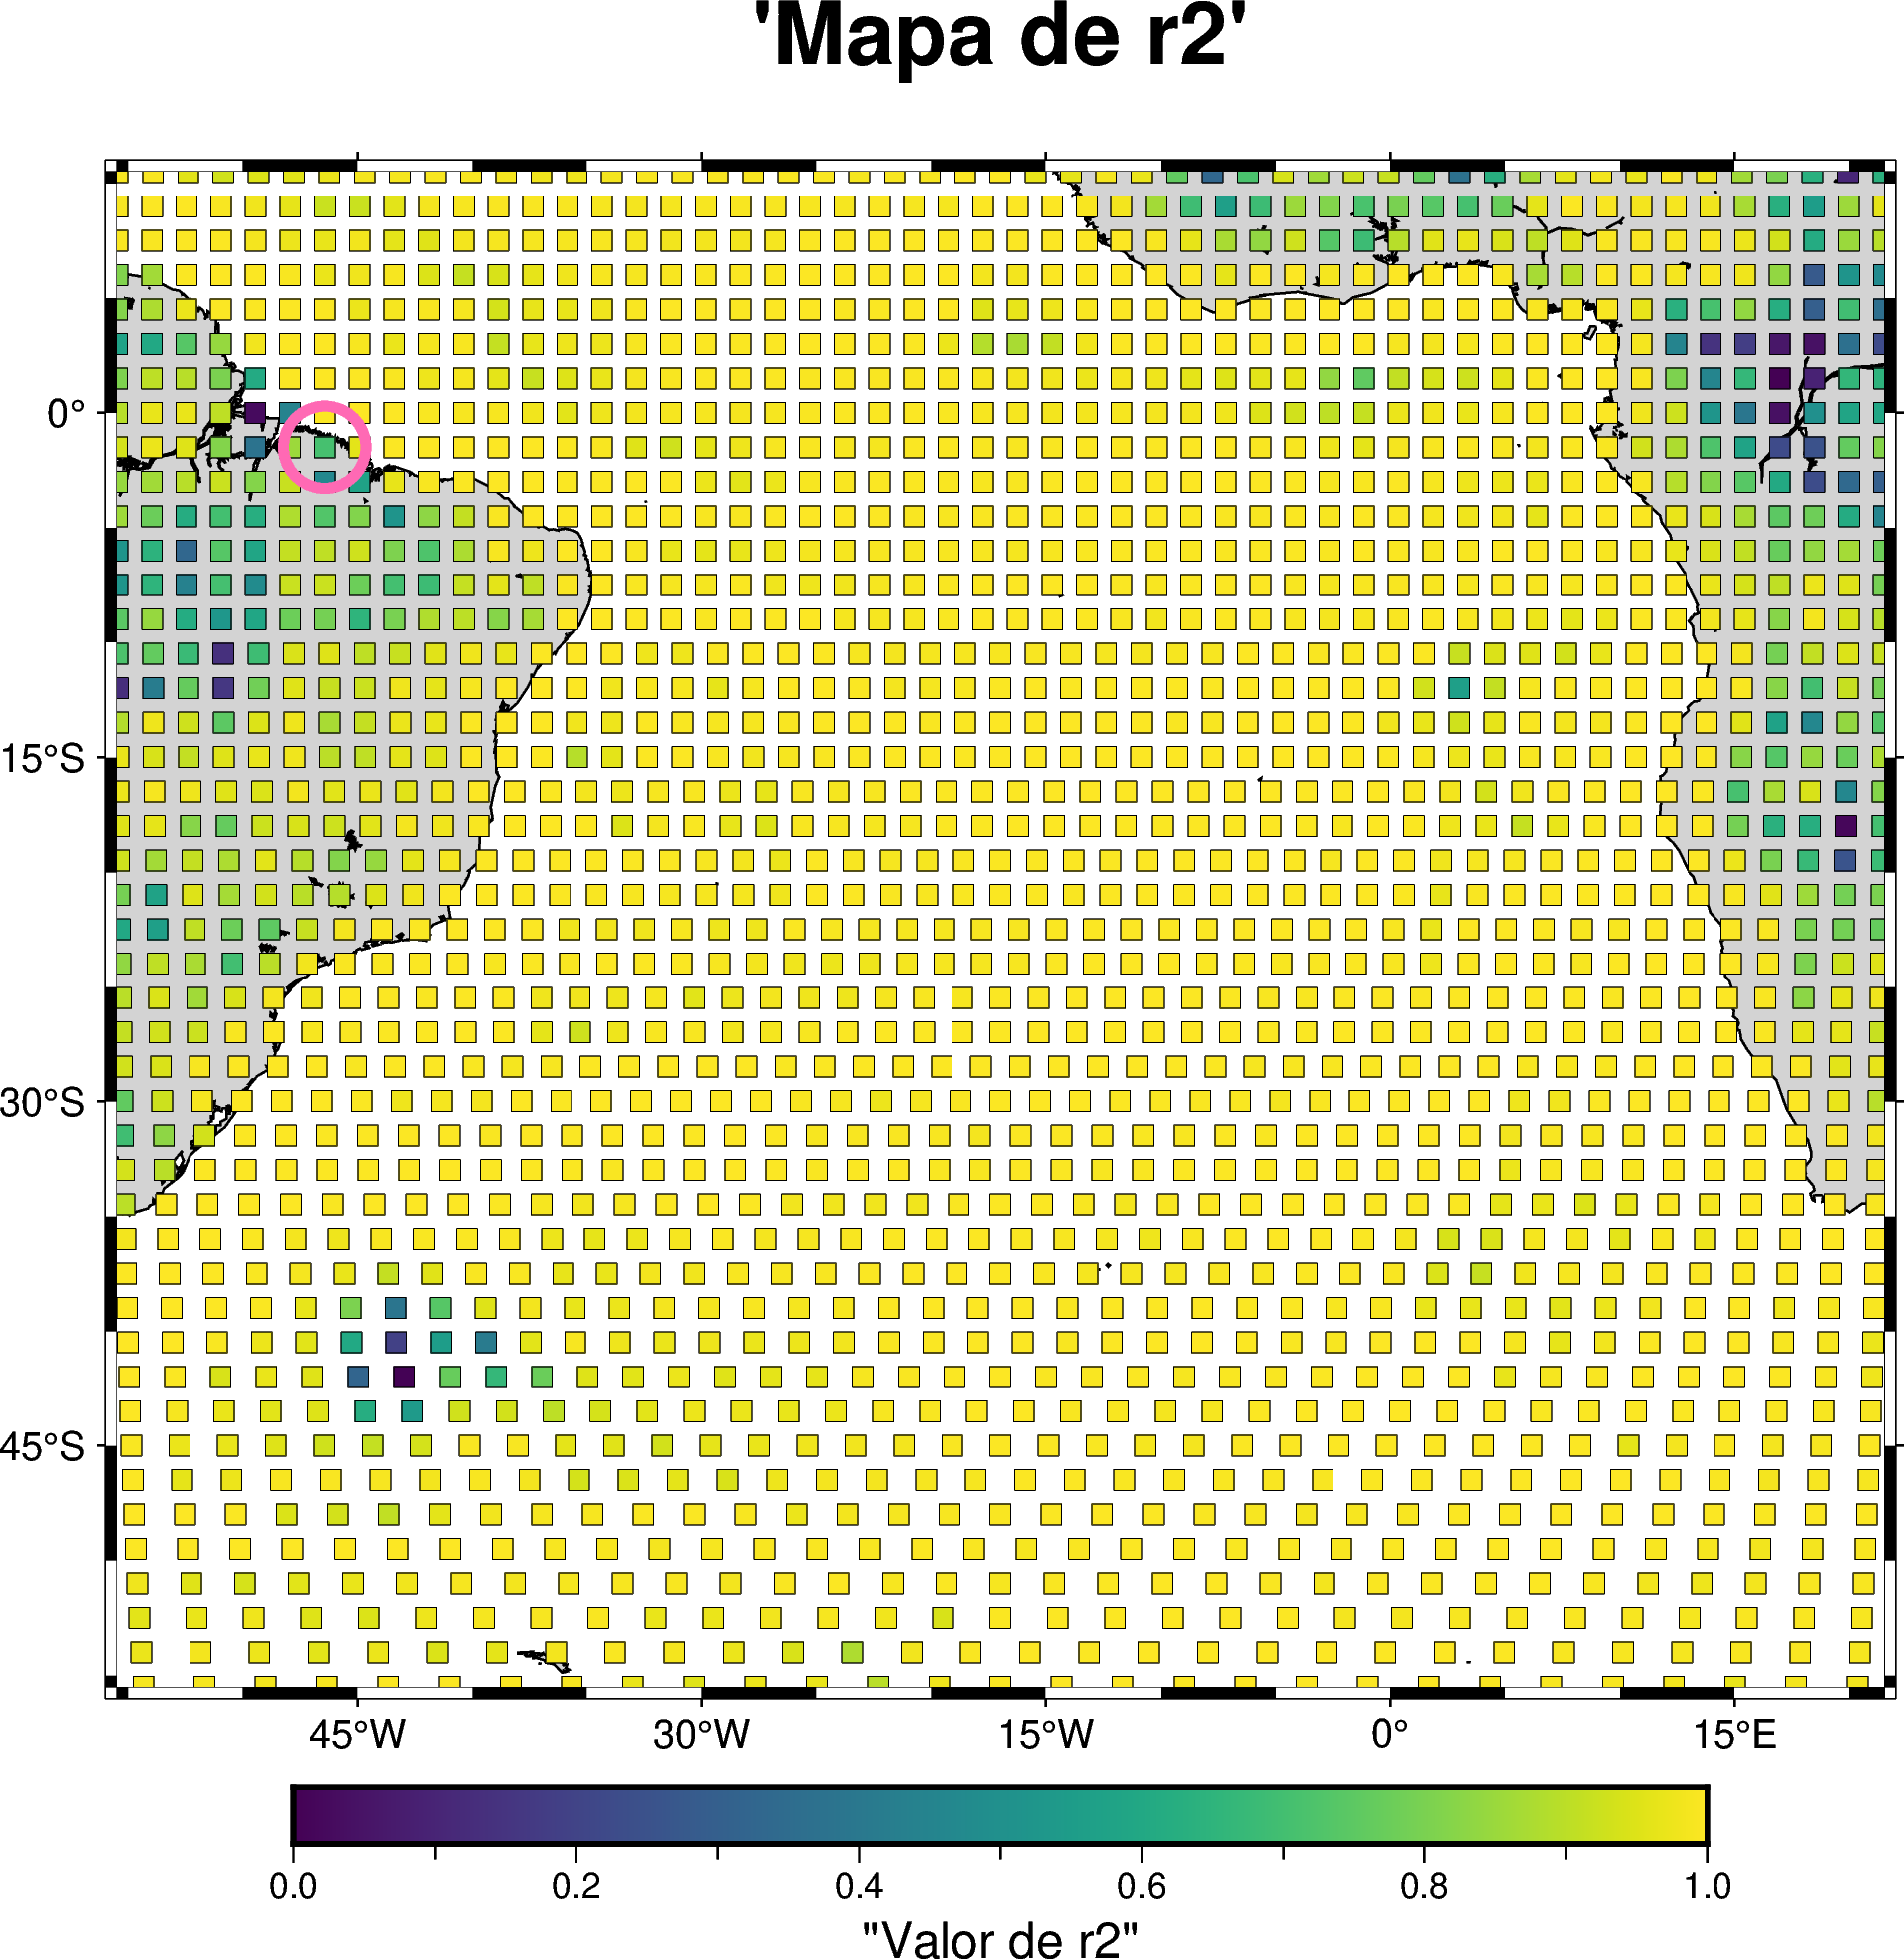

In [23]:

lon_alvo = df_windows.loc[i_wished_window, 'longitude']
lat_alvo = df_windows.loc[i_wished_window, 'latitude']

# 2. Gerar o mapa base (ele retorna o objeto 'fig')
fig = r.plot_parameters_map(df_windows, 'r2', v_range=[0, 1], step=0.01, cmap='viridis', reverse=False)

# 3. Desenhar um círculo de destaque sobre o mapa
# Criamos um "efeito de borda" com dois círculos sobrepostos
fig.plot(
    x=lon_alvo, 
    y=lat_alvo, 
    style='c0.7c',  # 'c' para circle, 0.7cm de tamanho
    pen='2.5p,hotpink' # Contorno branco grosso
)

print('O círculo rosa é a localização da janela.')
print()
fig.show()